In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2023WN folder and put all the files under P4 folder, then "2023WN/P4"
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2023WN/P4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/DeepROb/Mask_rcnn'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['rob599', 'PROPS-Detection-Dataset', 'two_stage_detector.py', '__pycache__', 'Mask_RCNN.ipynb', 'mask_rcnn.py', 'p3_helper.py']


In [4]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import locale
locale.getpreferredencoding = lambda: "UTF-8"

%pip install trimesh
%pip install pyrender
%pip install pyquaternion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.8/680.8 KB 39.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.9/978.9 KB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.3/831.3 KB 65.9 MB/s eta 0:00:00
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745208 sha256=99b9f3186008704192c161b69c23483569a6cec9d1ace9a40495b3a839f303b3
  Stored in directory: /root/.cache/pip/wheels/ff/a0/d3/f562b4c97f9b23a5c28dc55a3586a2f5c1d8af766cd8d9bd3a
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyO

In [5]:
import os
import time

os.environ["TZ"] = "US/Eastern"
time.tzset()

from mask_rcnn import hello_mask_rcnn
from p3_helper import hello_helper


hello_mask_rcnn()
hello_helper()

mask_rcnn_path = os.path.join(GOOGLE_DRIVE_PATH, "mask_rcnn.py")
mask_rcnn_edit_time = time.ctime(
    os.path.getmtime(mask_rcnn_path)
)
print("mask_rcnn.py last edited on %s" % mask_rcnn_edit_time)

Hello mask_rcnn.py!
Hello from p3_helper.py!
mask_rcnn.py last edited on Tue Apr  4 16:28:28 2023


In [6]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torchvision

%matplotlib inline

from p3_helper import *
from rob599 import reset_seed
from rob599.grad import rel_error

# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# To download the dataset
!pip install wget

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=41ba0d485c72bfa62ba38aeefe674cab9b51cf286c701cfd0c9574478853285a
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 6.44 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [7]:

if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


In [8]:
import multiprocessing

# Set a few constants related to data loading.
NUM_CLASSES = 10
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)
NUM_WORKERS = multiprocessing.cpu_count()

In [9]:
from p3_helper import PROPSDetectionDataset

# NOTE: Set `download=True` for the first time when you set up Google Drive folder.
# Turn it back to `False` later for faster execution in the future.
# If this hangs, download and place data in your drive manually.
train_dataset = PROPSDetectionDataset(
    GOOGLE_DRIVE_PATH, "train", image_size=IMAGE_SHAPE[0],
    download=False  # True (for the first time)
)
val_dataset = PROPSDetectionDataset(GOOGLE_DRIVE_PATH, "val", image_size=IMAGE_SHAPE[0])

print(f"Dataset sizes: train ({len(train_dataset)}), val ({len(val_dataset)})")




Dataset sizes: train (2500), val (2500)


In [10]:
# `pin_memory` speeds up CPU-GPU batch transfer, `num_workers=NUM_WORKERS` loads data
# on the main CPU process, suitable for Colab.
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Use batch_size = 1 during inference - during inference we do not center crop
# the image to detect all objects, hence they may be of different size. It is
# easier and less redundant to use batch_size=1 rather than zero-padding images.
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

train_loader_iter = iter(train_loader)
image_paths, images, gt_boxes = next(train_loader_iter)

print(f"image paths           : {image_paths}")
print(f"image batch has shape : {images.shape}")
print(f"gt_boxes has shape    : {gt_boxes.shape}")

print(f"Five boxes per image  :")
print(gt_boxes[:, :5, :])

image paths           : ['/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000000.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000001.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000002.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000003.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000004.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000005.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000006.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000007.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000008.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000009.jpg', '/content/drive/MyDrive/D

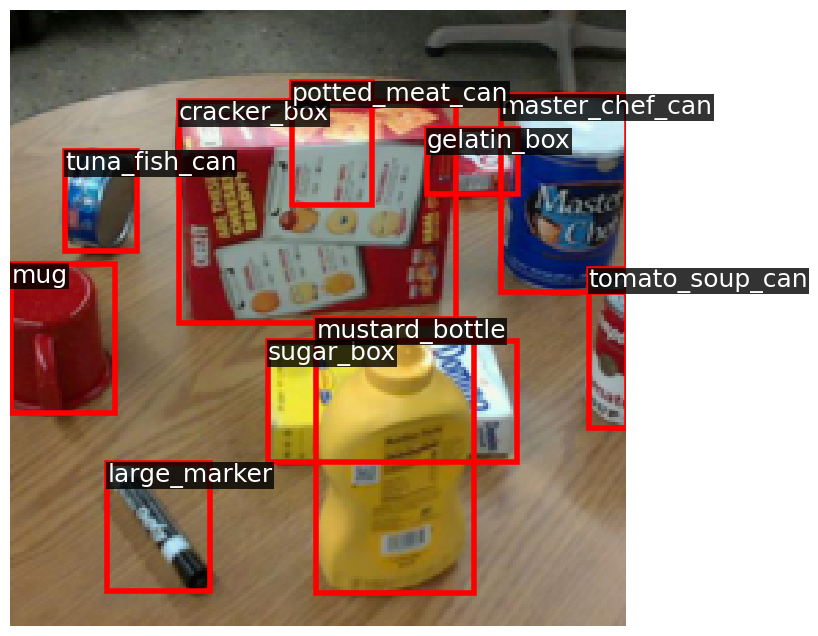

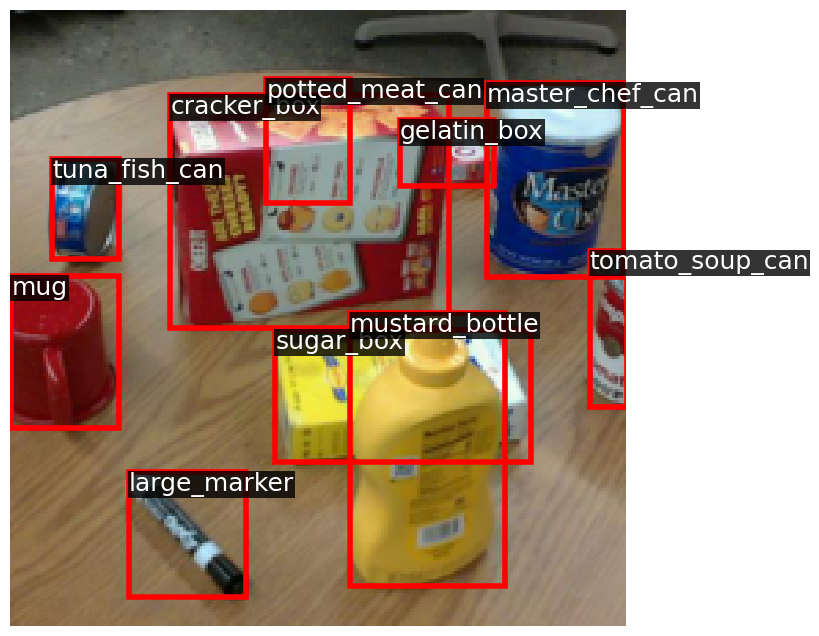

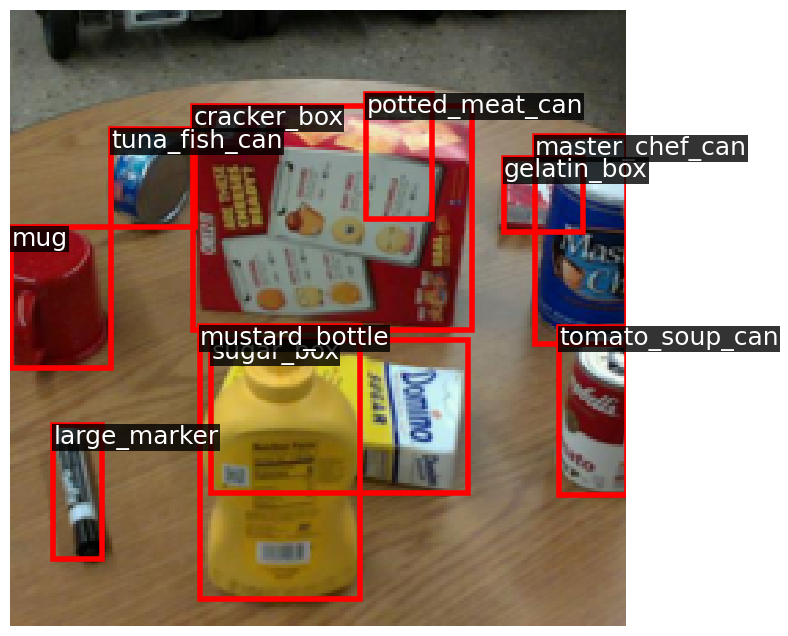

In [11]:
from torchvision import transforms
from rob599.utils import detection_visualizer

inverse_norm = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ]
)

for idx, (_, image, gt_boxes) in enumerate(train_dataset):
    if idx > 2:
        break

    image = inverse_norm(image)
    is_valid = gt_boxes[:, 4] >= 0
    detection_visualizer(image, val_dataset.idx_to_class, gt_boxes[is_valid])

In [12]:
# `pin_memory` speeds up CPU-GPU batch transfer, `num_workers=NUM_WORKERS` loads data
# on the main CPU process, suitable for Colab.
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Use batch_size = 1 during inference - during inference we do not center crop
# the image to detect all objects, hence they may be of different size. It is
# easier and less redundant to use batch_size=1 rather than zero-padding images.
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

train_loader_iter = iter(train_loader)
image_paths, images, gt_boxes = next(train_loader_iter)

print(f"image paths           : {image_paths}")
print(f"image batch has shape : {images.shape}")
print(f"gt_boxes has shape    : {gt_boxes.shape}")

print(f"Five boxes per image  :")
print(gt_boxes[:, :5, :])

image paths           : ['/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000000.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000001.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000002.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000003.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000004.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000005.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000006.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000007.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000008.jpg', '/content/drive/MyDrive/DeepROb/Mask_rcnn/PROPS-Detection-Dataset/PROPS-Detection/000009.jpg', '/content/drive/MyDrive/D

In [13]:
# Training a convolutional neural network (CNN) as the backbone of the Mask R-CNN model 
import torch
from mask_rcnn import DetectorBackboneWithFPN

backbone = DetectorBackboneWithFPN(out_channels=64)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_x_400mf-adf1edd5.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_400mf-adf1edd5.pth
100%|██████████| 21.3M/21.3M [00:00<00:00, 231MB/s]


For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])


In [14]:
print("Extra FPN modules added:")
print(backbone.fpn_params)

# Pass a batch of dummy images (random tensors) in NCHW format and observe the output.
dummy_images = torch.randn(2, 3, 224, 224)

# Collect dummy output.
dummy_fpn_feats = backbone(dummy_images)

print(f"For dummy input images with shape: {dummy_images.shape}")
for level_name, feat in dummy_fpn_feats.items():
    print(f"Shape of {level_name} features: {feat.shape}")

Extra FPN modules added:
ModuleDict(
  (L_c3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (L_c4): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
  (L_c5): Conv2d(400, 64, kernel_size=(1, 1), stride=(1, 1))
  (p3_o): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p4_o): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p5_o): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 features: torch.Size([2, 64, 28, 28])
Shape of p4 features: torch.Size([2, 64, 14, 14])
Shape of p5 features: torch.Size([2, 64, 7, 7])


In [15]:
from mask_rcnn import RPNPredictionNetwork


rpn_pred_net = RPNPredictionNetwork(
    in_channels=64, stem_channels=[64], num_anchors=3
)

# Pass the dummy FPN feats to RPN prediction network and view its output shapes.
dummy_rpn_obj, dummy_rpn_box = rpn_pred_net(dummy_fpn_feats)

# Few expected outputs:
# Shape of p4 RPN objectness: torch.Size([2, 196, 3])
# Shape of p5 RPN box deltas: torch.Size([2, 49, 12])

print(f"\nFor dummy input images with shape: {dummy_images.shape}")
for level_name in dummy_fpn_feats.keys():
    print(f"Shape of {level_name} FPN features  : {dummy_fpn_feats[level_name].shape}")
    print(f"Shape of {level_name} RPN objectness: {dummy_rpn_obj[level_name].shape}")
    print(f"Shape of {level_name} RPN box deltas: {dummy_rpn_box[level_name].shape}")
    print("")


For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 FPN features  : torch.Size([2, 64, 28, 28])
Shape of p3 RPN objectness: torch.Size([2, 2352])
Shape of p3 RPN box deltas: torch.Size([2, 2352, 4])

Shape of p4 FPN features  : torch.Size([2, 64, 14, 14])
Shape of p4 RPN objectness: torch.Size([2, 588])
Shape of p4 RPN box deltas: torch.Size([2, 588, 4])

Shape of p5 FPN features  : torch.Size([2, 64, 7, 7])
Shape of p5 RPN objectness: torch.Size([2, 147])
Shape of p5 RPN box deltas: torch.Size([2, 147, 4])



In [ ]:
from mask_rcnn import calculate_gt_masks
from torchvision import transforms
from rob599.utils import detection_visualizer

_, image, gt_boxes = train_dataset[0]
print(gt_boxes[1,:4])
gt_masks = calculate_gt_masks(gt_boxes[:,:4],image_size=(224,224))
print(gt_masks.shape)






tensor([ 61.0000,  32.6667, 161.8000, 113.4000])


ValueError: ignored

First five locations per FPN level (absolute image co-ordinates):
p3: [[4.0, 4.0], [4.0, 12.0], [4.0, 20.0], [4.0, 28.0], [4.0, 36.0]]
rel error:  0.0
p4: [[8.0, 8.0], [8.0, 24.0], [8.0, 40.0], [8.0, 56.0], [8.0, 72.0]]
rel error:  0.0
p5: [[16.0, 16.0], [16.0, 48.0], [16.0, 80.0], [16.0, 112.0], [16.0, 144.0]]
rel error:  0.0


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


********************************************************************************
All locations of the image FPN level = p3
stride = 8


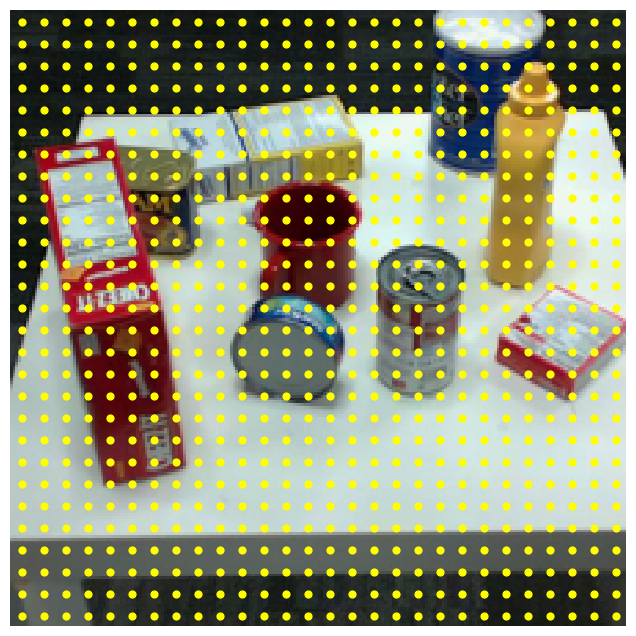

********************************************************************************
All locations of the image FPN level = p4
stride = 16


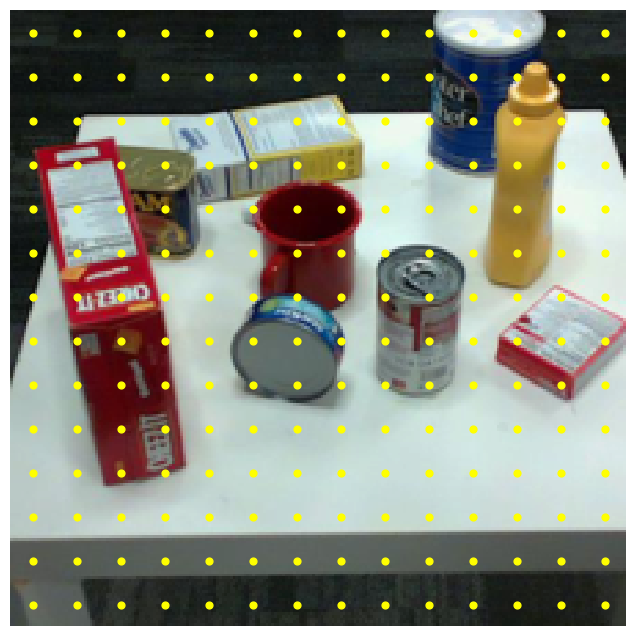

********************************************************************************
All locations of the image FPN level = p5
stride = 32


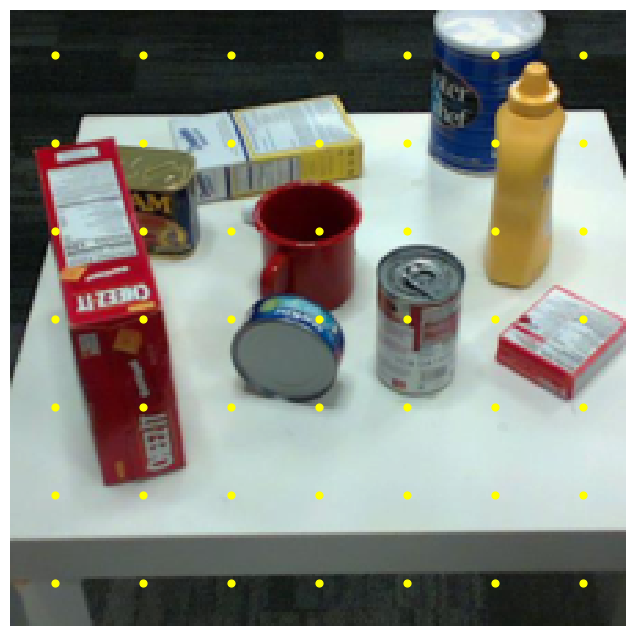

In [ ]:
from mask_rcnn import get_fpn_location_coords

# Get shapes of each FPN level feature map. We don't call these "dummy" because
# they don't depend on the _values_ of features, but rather only shapes.
fpn_feats_shapes = {
    level_name: feat.shape for level_name, feat in dummy_fpn_feats.items()
}

# Get CPU tensors for this sanity check: (you can pass `device=` argument.
locations_per_fpn_level = get_fpn_location_coords(fpn_feats_shapes, backbone.fpn_strides)

# First five location co-ordinates for each feature maps.
expected_locations = {
    "p3": torch.tensor([[4.0, 4.0], [4.0, 12.0], [4.0, 20.0], [4.0, 28.0], [4.0, 36.0]]),
    "p4": torch.tensor([[8.0, 8.0], [8.0, 24.0], [8.0, 40.0], [8.0, 56.0], [8.0, 72.0]]),
    "p5": torch.tensor([[16.0, 16.0], [16.0, 48.0], [16.0, 80.0], [16.0, 112.0], [16.0, 144.0]]),
}

print("First five locations per FPN level (absolute image co-ordinates):")
for level_name, locations in locations_per_fpn_level.items():
    print(f"{level_name}: {locations[:5, :].tolist()}")
    print("rel error: ", rel_error(expected_locations[level_name], locations[:5, :]))

# Visualize all the locations on first image from training data.
for level_name, locations in locations_per_fpn_level.items():
    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(val_dataset[0][1])

    print("*" * 80)
    print(f"All locations of the image FPN level = {level_name}")
    print(f"stride = {backbone.fpn_strides[level_name]}")
    detection_visualizer(image, val_dataset.idx_to_class, points=locations.tolist())

In [ ]:
from mask_rcnn import get_fpn_location_coords, generate_fpn_anchors


# Sanity check: Get 2x2 location co-ordinates of p5 (original shape is 7x7).
locations = get_fpn_location_coords(
    shape_per_fpn_level={"p5": (2, 64, 2, 2)}, strides_per_fpn_level={"p5": 32}
)

print("P5 locations:\n", locations["p5"])

# Generate anchors for these locations.
anchors = generate_fpn_anchors(
    locations_per_fpn_level=locations,
    strides_per_fpn_level={"p5": 32},
    stride_scale=2,
    aspect_ratios=[0.5, 1.0, 2.0],
)

print("P5 anchors with different aspect ratios:")
print("P5 1:2 anchors:\n", anchors["p5"][0::3, :], "\n")
# Expected (any ordering is fine):
# [-29.2548,  -6.6274,  61.2548,  38.6274]
# [-29.2548,  25.3726,  61.2548,  70.6274]
# [  2.7452,  -6.6274,  93.2548,  38.6274]
# [  2.7452,  25.3726,  93.2548,  70.6274]

print("P5 1:1 anchors:\n", anchors["p5"][1::3, :], "\n")
# Expected (any ordering is fine):
# [-16., -16.,  48.,  48.]
# [-16.,  16.,  48.,  80.]
# [ 16., -16.,  80.,  48.]
# [ 16.,  16.,  80.,  80.]

print("P5 2:1 anchors:\n", anchors["p5"][2::3, :], "\n")
# Similar to 1:2 anchors, but with flipped co-ordinates

P5 locations:
 tensor([[16., 16.],
        [16., 48.],
        [48., 16.],
        [48., 48.]])
P5 anchors with different aspect ratios:
P5 1:2 anchors:
 tensor([[-29.2548,  -6.6274,  61.2548,  38.6274],
        [-29.2548,  25.3726,  61.2548,  70.6274],
        [  2.7452,  -6.6274,  93.2548,  38.6274],
        [  2.7452,  25.3726,  93.2548,  70.6274]]) 

P5 1:1 anchors:
 tensor([[-16., -16.,  48.,  48.],
        [-16.,  16.,  48.,  80.],
        [ 16., -16.,  80.,  48.],
        [ 16.,  16.,  80.,  80.]]) 

P5 2:1 anchors:
 tensor([[ -6.6274, -29.2548,  38.6274,  61.2548],
        [ -6.6274,   2.7452,  38.6274,  93.2548],
        [ 25.3726, -29.2548,  70.6274,  61.2548],
        [ 25.3726,   2.7452,  70.6274,  93.2548]]) 



In [ ]:
import torch
from mask_rcnn import iou


boxes1 = torch.Tensor([[10, 10, 90, 90], [20, 20, 40, 40], [60, 60, 80, 80]])
boxes2 = torch.Tensor([[10, 10, 90, 90], [60, 60, 80, 80], [30, 30, 70, 70]])

expected_iou = torch.Tensor(
    [[1.0, 0.0625, 0.25], [0.0625, 0.0, 0.052631579], [0.0625, 1.0, 0.052631579]]
)
result_iou = iou(boxes1, boxes2)

print("Relative error:", rel_error(expected_iou, result_iou))

Relative error: 0.0


Unlabeled red box is positive anchor:


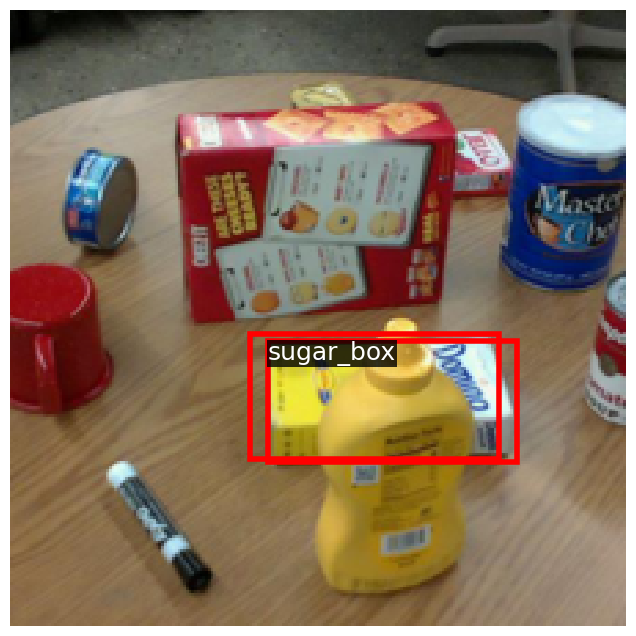

In [ ]:
import random
from mask_rcnn import get_fpn_location_coords, generate_fpn_anchors, rcnn_match_anchors_to_gt


# Sanity check: Match anchors of p3 level with GT boxes of first image
# in the training dataset.
_, image, gt_boxes = train_dataset[0]

FPN_LEVEL = "p3"
FPN_STRIDE = 8
locations = get_fpn_location_coords(
    shape_per_fpn_level={FPN_LEVEL: (2, 64, 224 // FPN_STRIDE, 224 // FPN_STRIDE)},
    strides_per_fpn_level={FPN_LEVEL: FPN_STRIDE}
)
# Generate anchors for these locations.
anchors = generate_fpn_anchors(
    locations_per_fpn_level=locations,
    strides_per_fpn_level={FPN_LEVEL: FPN_STRIDE},
    stride_scale=8,  # Default value used by Faster R-CNN
    aspect_ratios=[0.5, 1.0, 2.0],
)

matched_gt_boxes = rcnn_match_anchors_to_gt(
    anchors[FPN_LEVEL], gt_boxes, iou_thresholds=(0.3, 0.6)
)

# Flatten anchors and matched boxes:
anchors_p4 = anchors[FPN_LEVEL].view(-1, 4)
matched_boxes_p4 = matched_gt_boxes.view(-1, 5)

# Visualize one selected anchor and its matched GT box.
# NOTE: Run this cell multiple times to see different matched anchors. For car
# image, p3/5 will not work because the GT box was already assigned to p4.
fg_idxs_p4 = (matched_boxes_p4[:, 4] > 0).nonzero()
fg_idx = random.choice(fg_idxs_p4)

# Combine both boxes for visualization:
dummy_vis_boxes = [anchors_p4[fg_idx][0], matched_boxes_p4[fg_idx][0]]

print("Unlabeled red box is positive anchor:")
detection_visualizer(
    inverse_norm(image),
    val_dataset.idx_to_class,
    bbox=dummy_vis_boxes,
)

In [ ]:
import torch
from mask_rcnn import rcnn_get_deltas_from_anchors, rcnn_apply_deltas_to_anchors

# Three hard-coded anchor boxes and GT boxes that have a fairly high overlap.
# Add a dummy class ID = 1 indicating foreground
input_anchors = torch.Tensor(
    [[20, 40, 80, 90], [10, 10, 50, 50], [120, 100, 200, 200]]
)
input_boxes = torch.Tensor(
    [[10, 15, 100, 115, 1], [30, 20, 40, 30, 1], [120, 100, 200, 200, 1]]
)

# Here we do a simple sanity check - getting deltas for a particular set of boxes
# and applying them back to anchors should give us the same boxes.
_deltas = rcnn_get_deltas_from_anchors(input_anchors, input_boxes)
output_boxes = rcnn_apply_deltas_to_anchors(_deltas, input_anchors)

print("Rel error in reconstructed boxes:", rel_error(input_boxes[:, :4], output_boxes))

# Another check: deltas for GT class label = -1 should be -1e8
background_box = torch.Tensor([[-1, -1, -1, -1, -1]])
input_anchor = torch.Tensor([[100, 100, 200, 200]])

_deltas = rcnn_get_deltas_from_anchors(input_anchor, background_box)
output_box = rcnn_apply_deltas_to_anchors(_deltas, input_anchor)

print("Background deltas should be all -1e8  :", _deltas)
print("Output box should be -1e8 or lower    :", output_box)

Rel error in reconstructed boxes: 0.0
Background deltas should be all -1e8  : tensor([[-100000000., -100000000., -100000000., -100000000.]])
Output box should be -1e8 or lower    : tensor([[-1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10]])


In [ ]:
import torch
from torch.nn import functional as F


# Sanity check: dummy predictions from model - box regression deltas and
# objectness logits for two anchors.
# shape: (batch_size, HWA, 4 or 1)
dummy_pred_boxreg_deltas = torch.randn(1, 2, 4)
dummy_pred_obj_logits = torch.randn(1, 2, 1)

# Dummy deltas and objectness targets. Let the second box be background.
# Dummy GT boxes (matched with both anchors).
dummy_gt_deltas = torch.randn_like(dummy_pred_boxreg_deltas)
dummy_gt_deltas[:, 1, :] = -1e8

# Background objectness targets should be 0 (not -1), and foreground
# should be 1. Neutral anchors will not occur here due to sampling.
dummy_gt_objectness = torch.Tensor([1, 0])

# Note that loss is not multiplied with 0.25 here:
loss_box = F.l1_loss(
    dummy_pred_boxreg_deltas, dummy_gt_deltas, reduction="none"
)

# No loss for background anchors:
loss_box[dummy_gt_deltas == -1e8] *= 0.0
print("Box regression loss (L1):", loss_box)

# Now calculate objectness loss.
loss_obj = F.binary_cross_entropy_with_logits(
    dummy_pred_obj_logits.view(-1), dummy_gt_objectness, reduction="none"
)
print("Objectness loss (BCE):", loss_obj)

Box regression loss (L1): tensor([[[2.4818, 0.1388, 0.5981, 0.4321],
         [0.0000, 0.0000, 0.0000, 0.0000]]])
Objectness loss (BCE): tensor([0.6890, 0.2884])


In [ ]:
# Perform imports here to make this cell runnble independently,
# students are likely to spend good mount of time here and it is
# best to not require execution of prior cells.
import time
import torch
import torchvision

from mask_rcnn import nms
from rob599 import reset_seed

reset_seed(0)


boxes = (100.0 * torch.rand(5000, 4)).round()
boxes[:, 2] = boxes[:, 2] + boxes[:, 0] + 1.0
boxes[:, 3] = boxes[:, 3] + boxes[:, 1] + 1.0
scores = torch.randn(5000)

names = ["your_cpu", "torchvision_cpu", "torchvision_cuda"]
iou_thresholds = [0.3, 0.5, 0.7]
elapsed = dict(zip(names, [0.0] * len(names)))
intersects = dict(zip(names[1:], [0.0] * (len(names) - 1)))

for iou_threshold in iou_thresholds:
    tic = time.time()
    my_keep = nms(boxes, scores, iou_threshold)
    elapsed["your_cpu"] += time.time() - tic

    tic = time.time()
    tv_keep = torchvision.ops.nms(boxes, scores, iou_threshold)
    elapsed["torchvision_cpu"] += time.time() - tic
    intersect = len(set(tv_keep.tolist()).intersection(my_keep.tolist())) / len(tv_keep)
    intersects["torchvision_cpu"] += intersect

    tic = time.time()
    tv_cuda_keep = torchvision.ops.nms(boxes.to(device=DEVICE), scores.to(device=DEVICE), iou_threshold).to(
        my_keep.device
    )
    torch.cuda.synchronize()
    elapsed["torchvision_cuda"] += time.time() - tic
    intersect = len(set(tv_cuda_keep.tolist()).intersection(my_keep.tolist())) / len(
        tv_cuda_keep
    )
    intersects["torchvision_cuda"] += intersect

for key in intersects:
    intersects[key] /= len(iou_thresholds)

# You should see < 1% difference
print("Testing NMS:")
print("Your        CPU  implementation: %fs" % elapsed["your_cpu"])
print("torchvision CPU  implementation: %fs" % elapsed["torchvision_cpu"])
print("torchvision CUDA implementation: %fs" % elapsed["torchvision_cuda"])
print("Speedup CPU : %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cpu"]))
print("Speedup CUDA: %fx" % (elapsed["your_cpu"] / elapsed["torchvision_cuda"]))
print(
    "Difference CPU : ", 1.0 - intersects["torchvision_cpu"]
)  # in the order of 1e-3 or less
print(
    "Difference CUDA: ", 1.0 - intersects["torchvision_cuda"]
)  # in the order of 1e-3 or less

Testing NMS:
Your        CPU  implementation: 2.124493s
torchvision CPU  implementation: 0.100893s
torchvision CUDA implementation: 0.008056s
Speedup CPU : 21.056787x
Speedup CUDA: 263.710240x
Difference CPU :  0.0012674271229404788
Difference CUDA:  0.0


In [ ]:
from torch import nn

from p3_helper import train_detector
from mask_rcnn import DetectorBackboneWithFPN, RPN

reset_seed(0)

# Take equally spaced examples from training dataset to make a subset.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Create a wrapper module to contain backbone + RPN:
class FirstStage(nn.Module):
    def __init__(self, fpn_channels: int):
        super().__init__()
        self.backbone = DetectorBackboneWithFPN(out_channels=fpn_channels)
        self.rpn = RPN(
            fpn_channels=fpn_channels,
            # Simple stem of two layers:
            stem_channels=[fpn_channels, fpn_channels],
            batch_size_per_image=16,
            anchor_stride_scale=8,
            anchor_aspect_ratios=[0.5, 1.0, 2.0],
            anchor_iou_thresholds=(0.3, 0.6),
        )

    def forward(self, images, gt_boxes=None):
        feats_per_fpn_level = self.backbone(images)
        return self.rpn(feats_per_fpn_level, self.backbone.fpn_strides, gt_boxes)


first_stage = FirstStage(fpn_channels=64).to(DEVICE)

train_detector(
    first_stage,
    small_train_loader,
    learning_rate=8e-3,
    max_iters=1000,
    log_period=20,
    device=DEVICE,
)

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 0.972][loss_rpn_obj: 0.694][loss_rpn_box: 0.278]
[Iter 20][loss: 0.941][loss_rpn_obj: 0.689][loss_rpn_box: 0.253]
[Iter 40][loss: 0.927][loss_rpn_obj: 0.678][loss_rpn_box: 0.249]
[Iter 60][loss: 0.919][loss_rpn_obj: 0.674][loss_rpn_box: 0.245]


KeyboardInterrupt: ignored

In [22]:
from mask_rcnn import FasterRCNN
from mask_rcnn import MaskRCNN
from mask_rcnn import DetectorBackboneWithFPN, RPN


# Re-initialize dataset objects for independent debugging.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

FPN_CHANNELS = 64
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(
    fpn_channels=FPN_CHANNELS,
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=16,
    anchor_stride_scale=8,
    anchor_aspect_ratios=[0.5, 1.0, 2.0],
    anchor_iou_thresholds=(0.3, 0.6),
    pre_nms_topk=400,
    post_nms_topk=80,
)
# fmt: off
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=20, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
mask_rcnn = MaskRCNN(
    backbone, rpn, faster_rcnn,num_classes=20, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
# fmt: on

train_detector(
    mask_rcnn,
    small_train_loader,
    learning_rate=0.01,
    max_iters=1000,
    log_period=10,
    device=DEVICE,
)

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
gt_box torch.Size([16, 10, 5])
torch.Size([16, 10, 1])


AttributeError: ignored

In [ ]:
from mask_rcnn import MaskRCNN


# Re-initialize dataset objects for independent debugging.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

FPN_CHANNELS = 64
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(
    fpn_channels=FPN_CHANNELS,
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=16,
    anchor_stride_scale=8,
    anchor_aspect_ratios=[0.5, 1.0, 2.0],
    anchor_iou_thresholds=(0.3, 0.6),
    pre_nms_topk=400,
    post_nms_topk=80,
)
# fmt: off
mask_rcnn = MaskRCNN(
    backbone, rpn, num_classes=20, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
# fmt: on

train_detector(
    mask_rcnn,
    small_train_loader,
    learning_rate=0.01,
    max_iters=1000,
    log_period=10,
    device=DEVICE,
)